<a href="https://colab.research.google.com/github/WaGi-Coding/TakiBark_Colab-Notebook/blob/main/TakiBark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About

This is a Notebook to generate [Text-To-Speech(TTS)](https://en.wikipedia.org/wiki/Speech_synthesis) Audio with AI using [Bark](https://github.com/suno-ai/bark).<br>
<br>
I initially made it for myself, to make it easier to use, picking a language setting a seed, tune the settings, trim excessive silence, plot the comparison & so on.
<br><br>
#### Creator:<br>
* **GitHub:** [WaGi-Coding](https://github.com/WaGi-Coding)
* **Discord:** Taki7o7#1337
<br><br>

Repository can be found [HERE](https://github.com/WaGi-Coding/TakiBark_Colab-Notebook)

<br><br>

#### The Code-Thief has stolen code from following GitHub Repos:
*   [suno-ai/bark](https://github.com/suno-ai/bark/)
*   [C0untFloyd/bark-gui](https://github.com/C0untFloyd/bark-gui)

# RUN SETUP - This will take a while

**↓ RUN HERE**<br>



In [1]:
#@title RUN THIS SETUP!
import os
import sys

import torch

color_dict = {
    'black': '\033[90m',
    'red': '\033[91m',
    'green': '\033[92m',
    'yellow': '\033[93m',
    'blue': '\033[94m',
    'magenta': '\033[95m',
    'cyan': '\033[96m',
    'white': '\033[97m',
    'reset': '\033[0m'
}

def print_error_message(message, color='red', bold=True):
  boldAnsi = '';

  if bold:
    boldAnsi = '\33[1m'
  
  print(f'{color_dict[color]}{boldAnsi}{message}{color_dict["reset"]}')


if not torch.cuda.is_available():
  print_error_message('!!! CUDA NOT FOUND !!!')
  print_error_message('Make sure your Runtime is of a type that has GPU hardware acceleration!', color="yellow")
  sys.exit(1)
  sys.exit(1)

In [ ]:
#@title RUN THIS SETUP!
if not torch.cuda.is_available():
  sys.exit(1)
  
! pip install pytorch_seed

! git clone https://github.com/WaGi-Coding/bark
! cd bark && pip install .

! pip install pydub

import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


from IPython.display import Audio, clear_output
import nltk  # we'll use this to split into sentences
import numpy as np

from bark.generation import (
    generate_text_semantic,
    preload_models,
    _load_history_prompt,
)
from bark.api import semantic_to_waveform
from bark import generate_audio, SAMPLE_RATE
from typing import Dict, Optional, Union
import numpy as np
from bark.generation import codec_decode, generate_coarse, generate_fine, generate_text_semantic

# From: https://github.com/C0untFloyd/bark-gui/blob/main/bark/api.py
def generate_with_settings(text_prompt, semantic_temp=0.6, eos_p=0.2, coarse_temp=0.7, fine_temp=0.5, voice_name=None, output_full=False):

    # generation with more control
    x_semantic = generate_text_semantic(
        text_prompt,
        history_prompt=voice_name,
        temp=semantic_temp,
        min_eos_p = eos_p,
        use_kv_caching=True
    )

    x_coarse_gen = generate_coarse(
        x_semantic,
        history_prompt=voice_name,
        temp=coarse_temp,
        use_kv_caching=True
    )
    x_fine_gen = generate_fine(
        x_coarse_gen,
        history_prompt=voice_name,
        temp=fine_temp,
    )

    if output_full:
        full_generation = {
            'semantic_prompt': x_semantic,
            'coarse_prompt': x_coarse_gen,
            'fine_prompt': x_fine_gen
        }
        return full_generation, codec_decode(x_fine_gen)
    return codec_decode(x_fine_gen)


nltk.download('punkt')

In [3]:
#@title Setup Remove Silence Method
if not torch.cuda.is_available():
  sys.exit(1)


import soundfile as sf
from pydub import AudioSegment
from pydub.silence import split_on_silence


from pydub import AudioSegment

def trim_silence(input_file, output_file, silence_duration=3000, silence_threshold=-40):
    # Load the audio file
    audio = AudioSegment.from_file(input_file)

    # Split the audio into non-silent segments
    segments = split_on_silence(
        audio,
        min_silence_len=silence_duration,
        silence_thresh=silence_threshold,
        keep_silence=silence_duration / 2
    )

    # Concatenate the non-silent segments to create the trimmed audio
    trimmed_audio = segments[0]
    for segment in segments[1:]:
        trimmed_audio += segment

    # No need to normalize normally
    # Calculate the gain adjustment required to match the highest amplitude
    #gain_adjustment = audio.max_dBFS - trimmed_audio.max_dBFS

    # Apply amplitude normalization with gain adjustment
    #normalized_audio = trimmed_audio.apply_gain(gain_adjustment)

    # Export the trimmed and normalized audio to a new WAV file
    #normalized_audio.export(output_file, format='wav')

    trimmed_audio.export(output_file, format='wav')

    # Calculate the original and trimmed durations
    duration_original = len(audio) / 1000
    #duration_trimmed = len(normalized_audio) / 1000
    duration_trimmed = len(trimmed_audio) / 1000
    print("Original duration:", duration_original)
    print("Trimmed duration:", duration_trimmed)


In [4]:
#@title Setup Waveform Plotting Methods

if not torch.cuda.is_available():
  sys.exit(1)

import matplotlib.pyplot as plt
import numpy as np
import wave

# Set the global style parameters
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

def plot_wav(wav_data, sample_rate=None, ax=None, title="Waveform", waveformcolor="green"):
    try:
        if isinstance(wav_data, str):
            # If the input is a filename, load the WAV file
            with wave.open(wav_data, 'rb') as wav_file:
                params = wav_file.getparams()
                wav_data = np.frombuffer(wav_file.readframes(params.nframes), dtype=np.int16)
                sample_rate = params.framerate
        elif isinstance(wav_data, np.ndarray):
            if wav_data.ndim != 1:
                print("Error: Invalid waveform data. Only mono audio is supported.")
                return
            if sample_rate is None:
                print("Error: Sample rate must be provided for waveform data.")
                return
        else:
            print("Error: Invalid waveform data.")
            return
    except Exception as e:
        print(f"Error: Cannot plot comparison! Make sure you generated both audio files!")
        return None

    # Generate the time axis for the plot
    duration = len(wav_data) / sample_rate
    time = np.linspace(0, duration, num=len(wav_data))

    # Plot the audio signal on a new axis or the provided axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 2))
    ax.plot(time, wav_data, color=waveformcolor)  # Set waveform color to green
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)

    return ax


def plot_comparison(wav_file_path, wav_file_path2):
  try:
    # Load the first WAV file
    with wave.open(wav_file_path, 'rb') as wav_file:
        params = wav_file.getparams()
        wav_data_original = np.frombuffer(wav_file.readframes(params.nframes), dtype=np.int16)
        sample_rate = params.framerate

    # Load the second WAV file
    with wave.open(wav_file_path2, 'rb') as wav_file:
        params = wav_file.getparams()
        wav_data_cut = np.frombuffer(wav_file.readframes(params.nframes), dtype=np.int16)

    # Plot the first WAV file
    fig, ax = plt.subplots(figsize=(6, 2))
    ax = plot_wav(wav_data_original, sample_rate, ax=ax, title="Uncut", waveformcolor="white")

    if ax is not None:
        # Get the x-axis limits of the first plot
        x_min, x_max = ax.get_xlim()

        # Plot the second WAV file on a new axis with adjusted x-axis limits
        fig, ax2 = plt.subplots(figsize=(6, 2))
        ax2 = plot_wav(wav_data_cut, sample_rate, ax=ax2, title="Cut")
        ax2.set_xlim(x_min, x_max)

        # Get the y-axis limits of the first plot
        y_min, y_max = ax.get_ylim()

        # Apply the y-axis limits from the first plot to the second plot
        ax2.set_ylim(y_min, y_max)

        # Calculate the x-coordinate corresponding to the end of the first waveform
        duration_original = len(wav_data_original) / sample_rate
        x_end = duration_original

        # Add a vertical yellow line at the end of the first waveform
        ax.axvline(x_end, color='yellow', linestyle='--')

        # Calculate the x-coordinate corresponding to the end of the second waveform
        duration_cut = len(wav_data_cut) / sample_rate
        x_end2 = duration_cut

        # Add a vertical yellow line at the end of the second waveform
        ax2.axvline(x_end2, color='yellow', linestyle='--')

        # Show the plots
        plt.show()
    else:
        # Close the figure if an error occurred
        plt.close()
  except Exception as e:
    print(f"Error: Cannot plot comparison! Make sure you generated both audio files!")
    return

In [ ]:
#@title RUN THIS to preload the Models
#@markdown Takes some time :)
if not torch.cuda.is_available():
  sys.exit(1)

preload_models()

# $ \\ $

# Generation

In [6]:
#@title Run this & select a language.
#@markdown <b>Just a sidenote if you open the notebook later again and still see the output:</b><br>You always have to run it once, in order to register the observer which keeps track of the changes.

import ipywidgets as widgets
from IPython import display

def InitLangLangOptions():
    # 3rd parameter is an array of indexes which are female
    # 4th parameter is a dictionary with indexes optional additional tag
    LANGS = [
        ("English", "en", [9], {5: "Grainy", 6: "Suno Favorite"}),
        ("German", "de", [3, 8], {3: "Taki's Favorite"}),
        ("Spanish", "es", [8, 9], {2: "BG Noise", 3: "BG Noise", 5: "BG Noise"}),
        ("French", "fr", [1, 2, 5], {9: "Auditorium"}),
        ("Hindi", "hi", [0, 1, 3, 4, 9], {1: "BG Noise", 4: "BG Noise"}),
        ("Italian", "it", [2, 7, 9], {4: "Suno Favorite"}),
        ("Japanese", "ja", [0, 1, 3, 4, 5, 7, 8, 9], {1: "BG Noise"}),
        ("Korean", "ko", [0], {}),
        ("Polish", "pl", [4, 6, 9], {}),
        ("Portuguese", "pt", [], {6: "BG Noise"}),
        ("Russian", "ru", [5, 6, 9], {1: "Echoes", 2: "Echoes", 6: "Grainy", 8: "Grainy", 9: "Grainy"}),
        ("Turkish", "tr", [4, 5], {7: "Grainy"}),
        ("Chinese", "zh", [4, 6, 7, 9], {6: "BG Noise"}),
    ]
    
    # Create the category dropdown widget
    languages_dropdown = widgets.Dropdown(
        options=[lang[0] for lang in LANGS] + ["Misc."],
        description='Language:',
        layout=widgets.Layout(width='250px')
    )
    
    # Create the gender dropdown widget
    gender_dropdown = widgets.Dropdown(
        options=["All", "Male", "Female"],
        description='Gender:',
        layout=widgets.Layout(width='250px')
    )
    
    # Create the options dropdown widget
    options_dropdown = widgets.Dropdown(
        description='Options:',
        layout=widgets.Layout(width='350px')
    )
    
    # Function to update the options dropdown based on the selected category and gender
    def update_options_dropdown(change):
        selected_category = languages_dropdown.value
        selected_gender = gender_dropdown.value
    
        if selected_category == "Misc.":
            options_dropdown.options = [("announcer", "announcer")]
        else:
            lang = next((lang for lang in LANGS if lang[0] == selected_category), None)
            if lang:
                if selected_gender == "All":
                    options_dropdown.options = [
                        (f"v2{os.path.sep}{lang[1]}_speaker_{i}" + (f" | {lang[3].get(i)}" if i in lang[3] else ""), f"v2{os.path.sep}{lang[1]}_speaker_{i}")
                        for i in range(10)]
                elif selected_gender == "Male":
                    options_dropdown.options = [
                        (f"v2{os.path.sep}{lang[1]}_speaker_{i}" + (f" | {lang[3].get(i)}" if i in lang[3] else ""), f"v2{os.path.sep}{lang[1]}_speaker_{i}")
                        for i in range(10) if i not in lang[2]]

    
                elif selected_gender == "Female":
                    options_dropdown.options = [
                        (f"v2{os.path.sep}{lang[1]}_speaker_{i}" + (f" | {lang[3].get(i)}" if i in lang[3] else ""), f"v2{os.path.sep}{lang[1]}_speaker_{i}")
                        for i in lang[2]]
            else:
                options_dropdown.options = []
    
    
    # Register the function to be called when the category dropdown value changes
    languages_dropdown.observe(update_options_dropdown, names='value')
    
    # Register the function to be called when the gender dropdown value changes
    gender_dropdown.observe(update_options_dropdown, names='value')
    
    # Create an HBox widget container to horizontally arrange the dropdowns
    dropdown_container = widgets.HBox([languages_dropdown, gender_dropdown, options_dropdown])
    
    # Call the update_options_dropdown function initially to populate the options dropdown
    update_options_dropdown({'new': languages_dropdown.value})
    languages_dropdown.value = "English"
    gender_dropdown.value = "All"
    options_dropdown.value = "v2/en_speaker_9"
    # Display the dropdown widgets in the container
    display.display(dropdown_container)
    
    return languages_dropdown, gender_dropdown, options_dropdown

languages_dropdown, gender_dropdown, options_dropdown = InitLangLangOptions()

# Long-Form Generation
Because Bark works best with Text which would take ~14 seconds as it would become a weird mess if it's much longer:
<br>
We split longer text into sentences using `nltk` and generate the sentences one by one.
<br><br>
We will then combine the generated audio of each sentence together and output the full audio.

In [7]:
#@markdown Run this once to show the Textarea
textarea = widgets.Textarea(
    value='',
    placeholder='Input your Text here!',
    
    layout=widgets.Layout(width='600px', height='150px'),
    style={'resize': 'both'}
)

display.display(textarea)

Textarea(value='', layout=Layout(height='150px', width='600px'), placeholder='Input your Text here!')

In [8]:
#@title RUN THIS TO START GENERATING
import pytorch_seed

text = textarea.value
script = text.replace("\n", " ").strip()
sentences = nltk.sent_tokenize(script)

# seed <= 0 will be Radnom
seed = 0 #@param {type:"integer"}

# default 0.6
text_temp = 0.6 #@param {type:"number"}

# default 0.7
waveform_temp = 0.7 #@param {type:"number"}

# default 0.065
eos_prob = 0.065 #@param {type:"number"}

# default 0.25
sentence_end_silence = 0.25 #@param {type:"number"}

currentseed = seed
if seed != None and seed > 2**32 - 1:
    print(f"Seed {seed} > 2**32 - 1 (max), setting to random")
    currentseed = None
if currentseed == None or currentseed <= 0:
    currentseed = np.random.default_rng().integers(1, 2**32 - 1)

print(f"Selected speaker: {options_dropdown.value}");
print(f"Seed: {currentseed}")

silence = np.zeros(int(sentence_end_silence * SAMPLE_RATE))  # quarter second of silence

print(f"Sentence-Count: {len(sentences)}")

for i, sen in enumerate(sentences):
    print(f"{i+1}: {sen}")

pieces = []
csIdx = 1
with pytorch_seed.SavedRNG(currentseed):
  for sentence in sentences:
    print(f"Generating Sentence {csIdx}/{len(sentences)}: {sentence}")
    audio_array = generate_with_settings(text_prompt=sentence, voice_name=options_dropdown.value, semantic_temp=text_temp, coarse_temp=waveform_temp, eos_p=eos_prob)

    pieces += [audio_array, silence.copy()]
    csIdx += 1


Selected speaker: v2/en_speaker_9
Seed: 707
Sentence-Count: 8
1: Once, there was a boy who became bored when he watched over the village sheep grazing on the hillside.
2: To entertain himself, he sang out: "Wolf  Wolf!"
3: - "The wolf is chasing the sheep!"
4: When the villagers heard the cry, they came running up the hill to drive the wolf away.
5: But, when they arrived, they saw no wolf.
6: The boy was amused when seeing their angry faces.
7: "Don’t scream wolf, boy," warned the villagers, "when there is no wolf!"
8: They angrily went back down the hill.
Generating Sentence 1/8: Once, there was a boy who became bored when he watched over the village sheep grazing on the hillside.


100%|██████████| 36/36 [00:36<00:00,  1.01s/it]


Generating Sentence 2/8: To entertain himself, he sang out: "Wolf  Wolf!"


100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


Generating Sentence 3/8: - "The wolf is chasing the sheep!"


100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Generating Sentence 4/8: When the villagers heard the cry, they came running up the hill to drive the wolf away.


100%|██████████| 14/14 [00:13<00:00,  1.04it/s]


Generating Sentence 5/8: But, when they arrived, they saw no wolf.


100%|██████████| 17/17 [00:20<00:00,  1.18s/it]


Generating Sentence 6/8: The boy was amused when seeing their angry faces.


100%|██████████| 23/23 [00:21<00:00,  1.06it/s]


Generating Sentence 7/8: "Don’t scream wolf, boy," warned the villagers, "when there is no wolf!"


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


Generating Sentence 8/8: They angrily went back down the hill.


100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


In [9]:
#@markdown <--- Generate the Audio from the sentence pieces

sound = np.concatenate(pieces)

l_output = 'l_output.wav'
sf.write(l_output, sound, SAMPLE_RATE)


# We could directly pass the sound, but just to make sure they do not sound
# different for some reason, we load the saved file as array using sf

# Read the audio file using soundfile
data, samplerate = sf.read(l_output)
# Create a numpy array from the audio data
audio_array = np.array(data)


# Display the audio using Audio widget
myAudio = display.Audio(data=audio_array, rate=samplerate)
display.display(myAudio)

In [10]:
#@title Trim silent parts

# default 3000
max_silence = 3000 #@param {type:"integer"}

# default -40
threshold = -40 #@param {type:"integer"}


l_output_trimmed = 'l_output_trimmed.wav'

trim_silence(l_output, l_output_trimmed, silence_duration=max_silence, silence_threshold=threshold)


# Read the audio file using soundfile
data, samplerate = sf.read(l_output_trimmed)
# Create a numpy array from the audio data
audio_array = np.array(data)


# Display the audio using Audio widget
# display. Audio would also take a filepath, but for some reason it sounds like
# the Waveform lost Amplitude, while it actually did not. I guess how it loads
# from a Path directly is messed up, or i miss some parameter for doing so.
# Thats why we load it as array above!
myAudio = display.Audio(data=audio_array, rate=samplerate)
display.display(myAudio)

Original duration: 58.627
Trimmed duration: 51.677


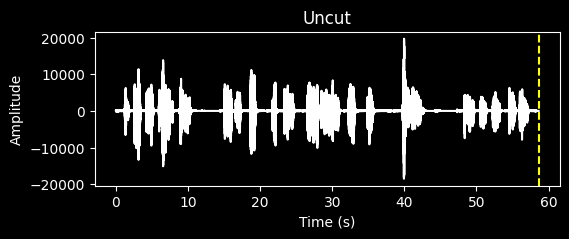

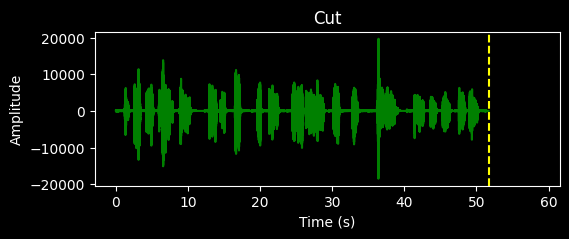

In [11]:
#@title Plot Waveform comparison
plot_comparison(l_output, l_output_trimmed)

# $ \\ $

# **Simple SHORT Generation**

In [15]:
#@title RUN THIS TO START GENERATING

import pytorch_seed

text = "Hey - I am Taki7o7 and this is my custom Bark Notebook. ... Feel free to try it out yourself!" #@param {type:"string"}

# seed <= 0 will be Radnom
seed = 0 #@param {type:"integer"}

# default 0.6
text_temp = 0.6 #@param {type:"number"}

# default 0.7
waveform_temp = 0.7 #@param {type:"number"}

# default 0.065
eos_prob = 0.065 #@param {type:"number"}


currentseed = seed
if seed != None and seed > 2**32 - 1:
    print(f"Seed {seed} > 2**32 - 1 (max), setting to random")
    currentseed = None
if currentseed == None or currentseed <= 0:
    currentseed = np.random.default_rng().integers(1, 2**32 - 1)

print(f"Selected speaker: {options_dropdown.value}");
print(f"Seed: {currentseed}")
print(f"Generating Sentence: {text}")

with pytorch_seed.SavedRNG(currentseed):
  audio_array = generate_with_settings(text_prompt=text, voice_name=options_dropdown.value, semantic_temp=text_temp, coarse_temp=waveform_temp, eos_p=eos_prob)


s_output = 's_output.wav'
sf.write(s_output, audio_array, SAMPLE_RATE)


# We could directly pass the sound, but just to make sure they do not sound
# different for some reason, we load the saved file as array using sf

# Read the audio file using soundfile
data, samplerate = sf.read(s_output)
# Create a numpy array from the audio data
audio_array = np.array(data)


# Display the audio using Audio widget
myAudio = display.Audio(data=audio_array, rate=samplerate)
display.display(myAudio)

Selected speaker: v2/en_speaker_9
Seed: 611650384
Generating Sentence: Hey - I am Taki7o7 and this is my custom Bark Notebook. ... Feel free to try it out yourself!


100%|██████████| 28/28 [00:26<00:00,  1.04it/s]


In [16]:
#@title Trim silent parts

# default 3000
max_silence = 1000 #@param {type:"integer"}

# default -40
threshold = -40 #@param {type:"integer"}


s_output_trimmed = 's_output_trimmed.wav'

trim_silence(s_output, s_output_trimmed, silence_duration=max_silence, silence_threshold=threshold)


# Read the audio file using soundfile
data, samplerate = sf.read(s_output_trimmed)
# Create a numpy array from the audio data
audio_array = np.array(data)


# Display the audio using Audio widget
# display. Audio would also take a filepath, but for some reason it sounds like
# the Waveform lost Amplitude, while it actually did not. I guess how it loads
# from a Path directly is messed up, or i miss some parameter for doing so.
# Thats why we load it as array above!
myAudio = display.Audio(data=audio_array, rate=samplerate)
display.display(myAudio)

Original duration: 10.973
Trimmed duration: 8.431


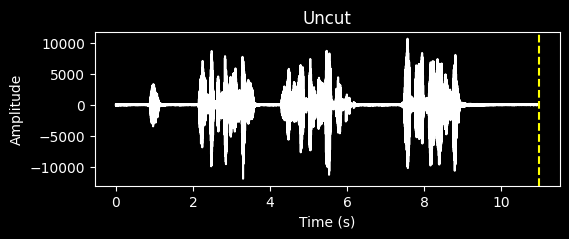

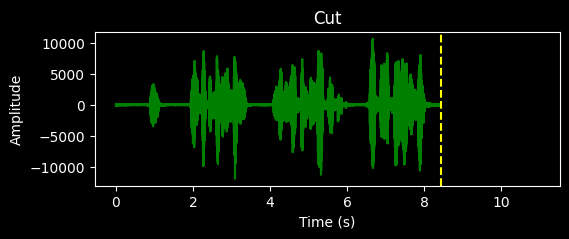

In [17]:
#@title Plot Waveform comparison
plot_comparison(s_output, s_output_trimmed)